In [98]:
from annoy import AnnoyIndex

In [99]:
import sqlite3
import random
import itertools
import subprocess
import os
import shlex
import time
import pickle
import joblib
from multiprocessing import Pool

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [101]:
from PIL import Image, ImageDraw, ImageFont

In [102]:
from imageio import imread

In [103]:
from skimage.transform import resize
from sklearn.decomposition import PCA, IncrementalPCA

In [104]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
# import tensorflow_datasets as tfds

In [105]:
print(tf.__version__)

2.4.1


In [106]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input
from tensorflow.keras.models import Model

# for tf 2
# from keras.applications.imagenet_utils import decode_predictions, preprocess_input

In [107]:
# this seems to help with some GPU memory issues

# import tensorflow as tf

# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.Session(config=config)

#### Set hyperparameters

In [108]:
# mode = "vgg"
# mode = "raw"
# mode = "dc"
# mode = "ternary"
mode = "cats"

In [109]:
# dataset_size = 2000 # testing
# dataset_size = 120000
dataset_size = 600000 # for saving IPCA files from 5% of data
# dataset_size = 1200000 # for testing larger ann files
batch_size = 2000
num_images = dataset_size

In [110]:
# ann_filename = "test_5k_pca.ann"
# ann_filename = "120k_ipca.ann"
# ann_filename = "120k_vgg_ipca.ann"

# ann_filename = "2k_pca.ann"
# ann_filename = "2k_ipca.ann"
# ann_filename = "2k_raw.ann"
# ann_filename = "2k_vgg_ipca.ann"
# ann_filename = "2k_ternary.ann"

# ann_filename = "600k_vgg_ipca.ann"
# ann_filename = "600k_raw.ann"
# ann_filename = "600k_ternary.ann"

# ann_filename = f'{dataset_size / 1000000:02.1f}m_{mode}.ann'
ann_filename = f'{dataset_size / 1000:01.0f}k_{mode}.ann'
print(ann_filename)

600k_cats.ann


#### load image filepaths

In [111]:
# image_list = "/home/rte/data/paths/all_converted_jpg_images_shuf.txt"
# image_list = "/home/rte/data/paths/all_images_ordered.txt"
image_list = "/home/rte/data/paths/all_images_shuf.txt"

# image_folder = "/home/rte/data/images/web/120k/"
image_folder = "/mnt/hd2/images/all/"

In [112]:
filepaths = []

with open(image_list, "r") as f:
    lines = f.readlines()
    print("length:",len(lines))
    print(lines[0])
for l in lines:
    # substrings = l.rsplit(",", 1)
    filepaths.append(l.strip())
    # image_ids.append(substrings[1].strip())

length: 12694664
4111723.jpg



In [113]:
# get the image paths for all images that we have features for
images = []

for i, f in enumerate(filepaths[:]):
    images.append(image_folder + f)
print(len(images))
print(images[:10])

12694664
['/mnt/hd2/images/all/4111723.jpg', '/mnt/hd2/images/all/8551267.jpg', '/mnt/hd2/images/all/11614912.jpg', '/mnt/hd2/images/all/7374806.jpg', '/mnt/hd2/images/all/11647173.jpg', '/mnt/hd2/images/all/3806900.jpg', '/mnt/hd2/images/all/6229183.jpg', '/mnt/hd2/images/all/10482597.jpg', '/mnt/hd2/images/all/5670666.jpg', '/mnt/hd2/images/all/10022332.jpg']


In [114]:
# resize to make sure we don't try and read more images than we have
filepaths = filepaths[:dataset_size]
print(len(filepaths))

600000


In [115]:
X = [] # images as arrays
dim = 256 # size of one dimension
f = dim * dim # size of vector
num_workers = 8

In [116]:
def load_img(path, dim):
    im = Image.open(path).convert('RGB')
    img_x, img_y = im.size

    # im.show()

    if False:
        x_bigger = True if img_x > img_y else False
        ratio = img_x / img_y

        if x_bigger:
            factor = float(dim) / img_y 
        else:
            factor = float(dim) / img_x
        new_x = int(img_x * factor)
        new_y = int(img_y * factor)

        resized = im.resize((new_x, new_y), Image.ANTIALIAS)
        # resized.show()

        left = (new_x - dim)/2
        top = (new_y - dim)/2
        right = (new_x + dim)/2
        bottom = (new_y + dim)/2

        cropped = resized.crop((left, top, right, bottom))
#         cropped.show()

#     print("factor", factor)
#     print("ratio", ratio)
#     print(x_bigger)
#     print("img_x", img_x)
#     print("img_y", img_y)
#     print(new_x, new_y)
#     print("cropped", cropped.size)

    if True:
        # just resize to fill the box
        just_resize = im.resize((dim, dim), Image.ANTIALIAS)
    #     just_resize.show()
        return just_resize

    if False:
        if x_bigger:
            factor = float(dim) / img_x
        else:
            factor = float(dim) / img_y
        new_x = int(img_x * factor)
        new_y = int(img_y * factor)
    #     print("factor", factor)
    #     print("img_x", img_x)
    #     print("img_y", img_y)
        crop_resized = im.resize((new_x, new_y), Image.ANTIALIAS)

        # pad
        padded = Image.new("RGB", (dim, dim))
        padded.paste(crop_resized, ((dim - new_x)//2, (dim - new_y)//2))
        padded.show()
    
#     return just_resize
    return cropped

In [117]:
def image_worker(filename):
    img_data = np.array(load_img(filename, dim))# - mean
    return img_data

def image_worker_flat(filename):
    img_data = np.array(load_img(filename, dim)).flatten()# - mean
    return img_data

def image_worker_vgg(filename):
    img, x = load_image(filename)
    return x

In [118]:
mean = np.array([224.03429894, 223.6761458, 223.62304944]) # mean for 120k

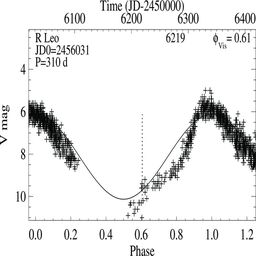

In [119]:
load_img(images[1], dim)

### Load images

Whole dataset

In [120]:
def load_all_data():
    image_batch = images[:num_images]
    overall_start = time.time()
    with Pool(num_workers) as p:
        X = p.map(image_worker_flat, image_batch)
    print(f"loaded {len(X)} images | time taken: {time.time() - overall_start}")
    return X

In [121]:
# X = load_all_data()

### Prepare feature extractor

In [122]:
if mode == "ternary":
    model_path = "/home/rte/re-imaging/classification/checkpoints/ternary_20190911_9748x/diagram-sensor-unsure_vgg16-2000.hdf5"
    model = keras.models.load_model(model_path)
    model.summary()

In [123]:
if mode == "vgg":
    model = keras.applications.VGG16(weights='imagenet', include_top=True)
    model.summary()

In [124]:
if mode == "cats":
    model = keras.models.load_model("../cats/save_at_50.h5")
    model.summary()
#     model.layers.pop()
#     model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 32)   896         rescaling[0][0]                  
______________________________________________________________________________________________

In [125]:
if mode in ("vgg", "ternary", "cats"):
    def load_image(path):
        img = image.load_img(path, target_size=model.input_shape[1:3])
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return img, x

shape of x:  (1, 180, 180, 3)
data type:  float32


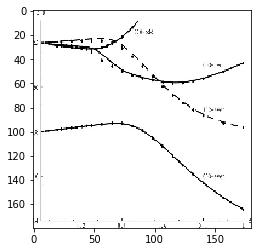

In [126]:
if mode in ("vgg", "ternary", "cats"):
    img, x = load_image(images[8])
    print("shape of x: ", x.shape)
    print("data type: ", x.dtype)
    plt.imshow(img)

In [127]:
if mode == "vgg":
    predictions = model.predict(x)

    for _, pred, prob in decode_predictions(predictions)[0]:
        print("predicted %s with probability %0.3f" % (pred, prob))

In [128]:
if mode == "vgg":
    feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
    feat_extractor.summary()
if mode == "ternary":
    feat_extractor = Model(inputs=model.input, outputs=model.get_layer("dense_1").output)
    feat_extractor.summary()
if mode == "cats":
    feat_extractor = Model(inputs=model.input, outputs=model.get_layer("dropout").output)
    feat_extractor.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 32)   896         rescaling[0][0]                  
____________________________________________________________________________________________

## Dimensionality Reduction

In [129]:
n_components = 300

### IncrementalPCA

In [130]:
ipca = IncrementalPCA(n_components=n_components, batch_size=16)

#### feed ipca in batches


In [131]:
# old_batch_size = batch_size
# batch_size = 500
assert dataset_size % batch_size == 0, "dataset_size not a multiple of batch_size"
divisions = [x for x in range(0, dataset_size, batch_size)]
print("divisions:",divisions)
overall_start = time.time()

for div in divisions:
    X = []
#     print("batch:",div,div+batch_size)
#     for i, image in enumerate(images[div:div+batch_size]):
#         img_data = np.array(load_img(images[i], dim)) - mean
#         X.append(img_data.flatten())
    
    if mode in ("vgg", "ternary", "cats"):
        print("loading images for VGG or ternary classifier")
        start = time.time()
        with Pool(num_workers) as p:
            X = p.map(image_worker_vgg, images[div:div+batch_size])
        print(f"batch{div,div+batch_size} - time to load images: {time.time() - start}")    

        # extract features
        features = []
        for x in X:
            feat = feat_extractor.predict(x)[0]
            features.append(feat)
        print(f"extracted features of {len(X)} images, time taken: {time.time() - start}")
        X = features
    else:
        print("loading images for raw processing")
        start = time.time()
        with Pool(num_workers) as p:
            X = p.map(image_worker_flat, images[div:div+batch_size])
        print(f"batch{div,div+batch_size} - time to load images: {time.time() - start}")    
        
    print(X[0])
    print(f'size of features: {len(X[0])}')
    print("size of data", len(X))
    start = time.time()
    ipca.partial_fit(X)
    print(f"partial fit time taken: {time.time() - start}")
print(f"total time taken: {time.time() - overall_start}")
# batch_size = old_batch_size

divisions: [0, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000, 32000, 34000, 36000, 38000, 40000, 42000, 44000, 46000, 48000, 50000, 52000, 54000, 56000, 58000, 60000, 62000, 64000, 66000, 68000, 70000, 72000, 74000, 76000, 78000, 80000, 82000, 84000, 86000, 88000, 90000, 92000, 94000, 96000, 98000, 100000, 102000, 104000, 106000, 108000, 110000, 112000, 114000, 116000, 118000, 120000, 122000, 124000, 126000, 128000, 130000, 132000, 134000, 136000, 138000, 140000, 142000, 144000, 146000, 148000, 150000, 152000, 154000, 156000, 158000, 160000, 162000, 164000, 166000, 168000, 170000, 172000, 174000, 176000, 178000, 180000, 182000, 184000, 186000, 188000, 190000, 192000, 194000, 196000, 198000, 200000, 202000, 204000, 206000, 208000, 210000, 212000, 214000, 216000, 218000, 220000, 222000, 224000, 226000, 228000, 230000, 232000, 234000, 236000, 238000, 240000, 242000, 244000, 246000, 248000, 250000, 252000, 254000, 256000, 258000, 260000

partial fit time taken: 0.4472677707672119
loading images for VGG or ternary classifier
batch(36000, 38000) - time to load images: 46.04546928405762
extracted features of 2000 images, time taken: 112.166175365448
[0.09542447 0.15037346 0.         ... 0.         0.03564774 0.00724596]
size of features: 1024
size of data 2000
partial fit time taken: 0.47713565826416016
loading images for VGG or ternary classifier
batch(38000, 40000) - time to load images: 44.409183740615845
extracted features of 2000 images, time taken: 110.31145858764648
[0.01048677 0.0319807  0.         ... 0.         0.00045258 0.        ]
size of features: 1024
size of data 2000
partial fit time taken: 0.45555710792541504
loading images for VGG or ternary classifier
batch(40000, 42000) - time to load images: 46.13789439201355
extracted features of 2000 images, time taken: 112.21743321418762
[0.05731486 0.24444447 0.0014021  ... 0.         0.14136422 0.00343516]
size of features: 1024
size of data 2000
partial fit tim

partial fit time taken: 0.4377868175506592
loading images for VGG or ternary classifier
batch(86000, 88000) - time to load images: 49.969006299972534
extracted features of 2000 images, time taken: 116.11809158325195
[0.01596593 0.09111378 0.02184517 ... 0.         0.06985641 0.        ]
size of features: 1024
size of data 2000
partial fit time taken: 0.4478123188018799
loading images for VGG or ternary classifier
batch(88000, 90000) - time to load images: 49.46685218811035
extracted features of 2000 images, time taken: 116.02683973312378
[0.03388506 0.11755739 0.         ... 0.         0.07239398 0.        ]
size of features: 1024
size of data 2000
partial fit time taken: 0.5143184661865234
loading images for VGG or ternary classifier
batch(90000, 92000) - time to load images: 49.618311405181885
extracted features of 2000 images, time taken: 115.86698913574219
[0.09515512 0.14516717 0.01351841 ... 0.         0.00323653 0.        ]
size of features: 1024
size of data 2000
partial fit ti

partial fit time taken: 0.44514966011047363
loading images for VGG or ternary classifier
batch(136000, 138000) - time to load images: 71.01140880584717
extracted features of 2000 images, time taken: 140.30697321891785
[0.06079374 0.15982641 0.00531302 ... 0.         0.05923549 0.        ]
size of features: 1024
size of data 2000
partial fit time taken: 0.876624345779419
loading images for VGG or ternary classifier
batch(138000, 140000) - time to load images: 95.91442513465881
extracted features of 2000 images, time taken: 163.73420906066895
[0.09428321 0.09758314 0.02246786 ... 0.         0.08102631 0.00490627]
size of features: 1024
size of data 2000
partial fit time taken: 0.5572881698608398
loading images for VGG or ternary classifier
batch(140000, 142000) - time to load images: 76.56122422218323
extracted features of 2000 images, time taken: 145.46847820281982
[0.04988307 0.16404906 0.0210923  ... 0.         0.14234832 0.        ]
size of features: 1024
size of data 2000
partial fi

partial fit time taken: 0.43506956100463867
loading images for VGG or ternary classifier
batch(186000, 188000) - time to load images: 54.68850088119507
extracted features of 2000 images, time taken: 120.86453580856323
[0.0482474  0.08577791 0.         ... 0.         0.04160053 0.00478272]
size of features: 1024
size of data 2000
partial fit time taken: 0.4510040283203125
loading images for VGG or ternary classifier
batch(188000, 190000) - time to load images: 50.41493535041809
extracted features of 2000 images, time taken: 117.14027976989746
[0.07162683 0.12406953 0.         ... 0.         0.00977141 0.        ]
size of features: 1024
size of data 2000
partial fit time taken: 0.4482717514038086
loading images for VGG or ternary classifier
batch(190000, 192000) - time to load images: 48.72930288314819
extracted features of 2000 images, time taken: 114.75010752677917
[0.04874951 0.1755276  0.00467129 ... 0.         0.08983847 0.00403021]
size of features: 1024
size of data 2000
partial f

partial fit time taken: 0.48752498626708984
loading images for VGG or ternary classifier
batch(236000, 238000) - time to load images: 39.796424865722656
extracted features of 2000 images, time taken: 107.08220362663269
[0.03266591 0.17429411 0.00512407 ... 0.         0.1094467  0.        ]
size of features: 1024
size of data 2000
partial fit time taken: 0.4703652858734131
loading images for VGG or ternary classifier
batch(238000, 240000) - time to load images: 37.17511701583862
extracted features of 2000 images, time taken: 104.8137698173523
[0.01067152 0.09469598 0.         ... 0.         0.09078576 0.        ]
size of features: 1024
size of data 2000
partial fit time taken: 0.49611926078796387
loading images for VGG or ternary classifier
batch(240000, 242000) - time to load images: 36.77136778831482
extracted features of 2000 images, time taken: 104.98956108093262
[0.01371194 0.08088468 0.         ... 0.         0.03698607 0.00913123]
size of features: 1024
size of data 2000
partial 

partial fit time taken: 0.5117228031158447
loading images for VGG or ternary classifier
batch(286000, 288000) - time to load images: 43.27898669242859
extracted features of 2000 images, time taken: 110.70704936981201
[0.06941175 0.10042751 0.         ... 0.         0.07065471 0.        ]
size of features: 1024
size of data 2000
partial fit time taken: 0.5027449131011963
loading images for VGG or ternary classifier
batch(288000, 290000) - time to load images: 44.63125014305115
extracted features of 2000 images, time taken: 111.27087473869324
[0.04121725 0.1108105  0.00262208 ... 0.         0.06508519 0.0034943 ]
size of features: 1024
size of data 2000
partial fit time taken: 0.5126042366027832
loading images for VGG or ternary classifier
batch(290000, 292000) - time to load images: 45.320603132247925
extracted features of 2000 images, time taken: 112.23861265182495
[0.07769236 0.13930047 0.0138921  ... 0.         0.03172615 0.        ]
size of features: 1024
size of data 2000
partial f

partial fit time taken: 0.5068755149841309
loading images for VGG or ternary classifier
batch(336000, 338000) - time to load images: 43.21341061592102
extracted features of 2000 images, time taken: 110.28212380409241
[0.03309922 0.06697179 0.07664493 ... 0.00426883 0.294318   0.00299154]
size of features: 1024
size of data 2000
partial fit time taken: 0.6126511096954346
loading images for VGG or ternary classifier
batch(338000, 340000) - time to load images: 44.94025135040283
extracted features of 2000 images, time taken: 111.24770665168762
[0.16021742 0.31124914 0.05433815 ... 0.01044341 0.2976839  0.        ]
size of features: 1024
size of data 2000
partial fit time taken: 0.4728868007659912
loading images for VGG or ternary classifier
batch(340000, 342000) - time to load images: 43.51348423957825
extracted features of 2000 images, time taken: 110.66274404525757
[0.04494872 0.11487142 0.00104577 ... 0.         0.03488857 0.02616806]
size of features: 1024
size of data 2000
partial fi

partial fit time taken: 0.46128153800964355
loading images for VGG or ternary classifier
batch(386000, 388000) - time to load images: 86.74156355857849
extracted features of 2000 images, time taken: 153.19651913642883
[0.0307393  0.18640332 0.02115828 ... 0.         0.30739504 0.00253224]
size of features: 1024
size of data 2000
partial fit time taken: 0.48503589630126953
loading images for VGG or ternary classifier
batch(388000, 390000) - time to load images: 79.97670006752014
extracted features of 2000 images, time taken: 146.7153182029724
[0.04717733 0.15882827 0.0135022  ... 0.00023811 0.10035038 0.02239814]
size of features: 1024
size of data 2000
partial fit time taken: 0.4541597366333008
loading images for VGG or ternary classifier
batch(390000, 392000) - time to load images: 76.2912585735321
extracted features of 2000 images, time taken: 143.44567775726318
[0.06165155 0.05824842 0.0048215  ... 0.         0.02807106 0.        ]
size of features: 1024
size of data 2000
partial fi

partial fit time taken: 0.548877477645874
loading images for VGG or ternary classifier
batch(436000, 438000) - time to load images: 45.2019476890564
extracted features of 2000 images, time taken: 112.46119117736816
[0.05080877 0.1556543  0.01729264 ... 0.00070866 0.02140095 0.        ]
size of features: 1024
size of data 2000
partial fit time taken: 0.5109972953796387
loading images for VGG or ternary classifier
batch(438000, 440000) - time to load images: 45.25270891189575
extracted features of 2000 images, time taken: 112.40304279327393
[0.09727239 0.19568425 0.         ... 0.         0.05674179 0.        ]
size of features: 1024
size of data 2000
partial fit time taken: 0.5818796157836914
loading images for VGG or ternary classifier
batch(440000, 442000) - time to load images: 44.00969743728638
extracted features of 2000 images, time taken: 110.58616590499878
[0.06016941 0.07744814 0.00506571 ... 0.         0.03282113 0.00311199]
size of features: 1024
size of data 2000
partial fit 

partial fit time taken: 0.43510007858276367
loading images for VGG or ternary classifier
batch(486000, 488000) - time to load images: 41.88956308364868
extracted features of 2000 images, time taken: 107.84547448158264
[0.11501431 0.16109295 0.00283679 ... 0.         0.04229513 0.        ]
size of features: 1024
size of data 2000
partial fit time taken: 0.47876954078674316
loading images for VGG or ternary classifier
batch(488000, 490000) - time to load images: 43.39603281021118
extracted features of 2000 images, time taken: 109.85310983657837
[0.00636833 0.04143267 0.         ... 0.         0.02585883 0.        ]
size of features: 1024
size of data 2000
partial fit time taken: 0.5250799655914307
loading images for VGG or ternary classifier
batch(490000, 492000) - time to load images: 41.65971827507019
extracted features of 2000 images, time taken: 107.4944760799408
[0.07613809 0.18315142 0.00656149 ... 0.         0.03045874 0.00646028]
size of features: 1024
size of data 2000
partial f

partial fit time taken: 0.44699835777282715
loading images for VGG or ternary classifier
batch(536000, 538000) - time to load images: 46.170183181762695
extracted features of 2000 images, time taken: 112.2479419708252
[0.04675031 0.09965147 0.02578883 ... 0.         0.06167065 0.        ]
size of features: 1024
size of data 2000
partial fit time taken: 0.43497347831726074
loading images for VGG or ternary classifier
batch(538000, 540000) - time to load images: 46.06543493270874
extracted features of 2000 images, time taken: 111.89294695854187
[0.00675963 0.11308631 0.0036558  ... 0.         0.07317889 0.        ]
size of features: 1024
size of data 2000
partial fit time taken: 0.4424722194671631
loading images for VGG or ternary classifier
batch(540000, 542000) - time to load images: 45.66037130355835
extracted features of 2000 images, time taken: 112.11191892623901
[0.06474175 0.29014885 0.         ... 0.         0.08789937 0.00483126]
size of features: 1024
size of data 2000
partial 

partial fit time taken: 0.46560192108154297
loading images for VGG or ternary classifier
batch(586000, 588000) - time to load images: 47.793824911117554
extracted features of 2000 images, time taken: 114.39890503883362
[0.05278533 0.09091663 0.         ... 0.         0.02824018 0.        ]
size of features: 1024
size of data 2000
partial fit time taken: 0.43973660469055176
loading images for VGG or ternary classifier
batch(588000, 590000) - time to load images: 47.297064542770386
extracted features of 2000 images, time taken: 113.48939800262451
[0.10722954 0.14633018 0.03308468 ... 0.         0.0240573  0.        ]
size of features: 1024
size of data 2000
partial fit time taken: 0.44679832458496094
loading images for VGG or ternary classifier
batch(590000, 592000) - time to load images: 46.07457661628723
extracted features of 2000 images, time taken: 112.63692569732666
[0.10588619 0.21992539 0.01514282 ... 0.         0.1525983  0.        ]
size of features: 1024
size of data 2000
parti

In [132]:
# img, x = load_image(images[8])
# feat = feat_extractor.predict(x)[0]
# print(feat)
# print(len(feat))

In [133]:
# X_ipca = ipca.transform(X)

In [134]:
# joblib_path = "ipca_2k_test.joblib"
# joblib_path = "ipca_120k_test.joblib"
joblib_path = ann_filename.split(".")[0] + "_ipca.joblib"

In [135]:
print(joblib_path)

600k_cats_ipca.joblib


In [136]:
# write joblib file to save ipca
with open(joblib_path, "wb") as f:
    joblib.dump(ipca, f)

In [137]:
print("n_samples_seen_:", ipca.n_samples_seen_)

n_samples_seen_: 600000


#### Load ipca
Testing only

In [138]:
# with open(joblib_path, "rb") as f:
#     load_ipca = joblib.load(f) 

In [139]:
# print(load_ipca.components_)

In [140]:
# print(load_ipca.explained_variance_)

In [141]:
# print(load_ipca.explained_variance_ratio_)

In [142]:
# plt.plot(np.cumsum(load_ipca.explained_variance_ratio_))
# plt.title(joblib_path)
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');
# plot_savename = joblib_path.split(".")[0] + "_expvarrat.png"
# plt.savefig(plot_savename, dpi=300)

### Approximate Nearest Neighbours

In [143]:
# pca
t = AnnoyIndex(300, 'angular')  # Length of item vector that will be indexed

# raw
# t = AnnoyIndex(256*256*3, 'angular')  # Length of item vector that will be indexed

t.set_seed(10)

In [144]:
# feed annoy all in one go

# annoy_data = X_pca
# annoy_data = X_ipca
# # annoy_data = X
# print("length of annoy_data:", len(annoy_data))

# for i, item in enumerate(annoy_data):
#     t.add_item(i, item)

# start = time.time()
# t.build(10) # 10 trees
# t.save(ann_filename)
# print(f"added all to annoy, time taken: {time.time() - start}")

In [145]:
# feed annoy in batches
assert dataset_size % batch_size == 0, "dataset_size not a multiple of batch_size"
divisions = [x for x in range(0, dataset_size, batch_size)]
print("divisions:",divisions)
overall_start = time.time()

counter = 0

for div in divisions:
    X = []
#     print("batch:",div,div+batch_size)
#     for i, image in enumerate(images[div:div+batch_size]):
#         img_data = np.array(load_img(images[i], dim)) - mean
#         X.append(img_data.flatten())

    if mode in ("vgg", "ternary", "cats"):
        print("loading images for VGG")
        start = time.time()
        with Pool(num_workers) as p:
            X = p.map(image_worker_vgg, images[div:div+batch_size])
        print(f"batch{div,div+batch_size} - time to load images: {time.time() - start}")    

        # extract features
        features = []
        for x in X:
            feat = feat_extractor.predict(x)[0]
            features.append(feat)
        print(f"extracted features of {len(X)} images, time taken: {time.time() - start}")
        X = features
    else:
        print("loading images for raw")
        start = time.time()
        with Pool(num_workers) as p:
            X = p.map(image_worker_flat, images[div:div+batch_size])
        print(f"batch{div,div+batch_size} - loading time taken: {time.time() - start}")
    start = time.time()
    ipca_X = ipca.transform(X)
    print(f"transform time taken: {time.time() - start}")
    start = time.time()
    for i, item in enumerate(ipca_X):
        t.add_item(counter, item)
        counter += 1
    print(f"annoy add items time taken: {time.time() - start}")
print(f"total time taken: {time.time() - overall_start}")

t.build(10) # 10 trees
t.save(ann_filename)

divisions: [0, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000, 32000, 34000, 36000, 38000, 40000, 42000, 44000, 46000, 48000, 50000, 52000, 54000, 56000, 58000, 60000, 62000, 64000, 66000, 68000, 70000, 72000, 74000, 76000, 78000, 80000, 82000, 84000, 86000, 88000, 90000, 92000, 94000, 96000, 98000, 100000, 102000, 104000, 106000, 108000, 110000, 112000, 114000, 116000, 118000, 120000, 122000, 124000, 126000, 128000, 130000, 132000, 134000, 136000, 138000, 140000, 142000, 144000, 146000, 148000, 150000, 152000, 154000, 156000, 158000, 160000, 162000, 164000, 166000, 168000, 170000, 172000, 174000, 176000, 178000, 180000, 182000, 184000, 186000, 188000, 190000, 192000, 194000, 196000, 198000, 200000, 202000, 204000, 206000, 208000, 210000, 212000, 214000, 216000, 218000, 220000, 222000, 224000, 226000, 228000, 230000, 232000, 234000, 236000, 238000, 240000, 242000, 244000, 246000, 248000, 250000, 252000, 254000, 256000, 258000, 260000

extracted features of 2000 images, time taken: 109.87924003601074
transform time taken: 0.015137910842895508
annoy add items time taken: 0.10303854942321777
loading images for VGG
batch(50000, 52000) - time to load images: 43.077682971954346
extracted features of 2000 images, time taken: 109.12409090995789
transform time taken: 0.018955707550048828
annoy add items time taken: 0.10106348991394043
loading images for VGG
batch(52000, 54000) - time to load images: 42.69535231590271
extracted features of 2000 images, time taken: 111.68904447555542
transform time taken: 0.01760125160217285
annoy add items time taken: 0.10138392448425293
loading images for VGG
batch(54000, 56000) - time to load images: 43.68068599700928
extracted features of 2000 images, time taken: 109.34681296348572
transform time taken: 0.02028179168701172
annoy add items time taken: 0.10175037384033203
loading images for VGG
batch(56000, 58000) - time to load images: 42.196524143218994
extracted features of 2000 images, t

extracted features of 2000 images, time taken: 108.09194588661194
transform time taken: 0.016602754592895508
annoy add items time taken: 0.10107755661010742
loading images for VGG
batch(118000, 120000) - time to load images: 41.05675935745239
extracted features of 2000 images, time taken: 107.52781867980957
transform time taken: 0.016686201095581055
annoy add items time taken: 0.10064315795898438
loading images for VGG
batch(120000, 122000) - time to load images: 41.334139347076416
extracted features of 2000 images, time taken: 107.95244932174683
transform time taken: 0.01720714569091797
annoy add items time taken: 0.10105252265930176
loading images for VGG
batch(122000, 124000) - time to load images: 41.43137788772583
extracted features of 2000 images, time taken: 107.98169875144958
transform time taken: 0.02089381217956543
annoy add items time taken: 0.10034036636352539
loading images for VGG
batch(124000, 126000) - time to load images: 41.50231862068176
extracted features of 2000 im

extracted features of 2000 images, time taken: 112.66250348091125
transform time taken: 0.020122289657592773
annoy add items time taken: 0.10191822052001953
loading images for VGG
batch(186000, 188000) - time to load images: 44.462443828582764
extracted features of 2000 images, time taken: 111.94110774993896
transform time taken: 0.019023656845092773
annoy add items time taken: 0.10889935493469238
loading images for VGG
batch(188000, 190000) - time to load images: 46.148104190826416
extracted features of 2000 images, time taken: 113.26290917396545
transform time taken: 0.015692472457885742
annoy add items time taken: 0.10041356086730957
loading images for VGG
batch(190000, 192000) - time to load images: 43.604713678359985
extracted features of 2000 images, time taken: 111.03157687187195
transform time taken: 0.018067598342895508
annoy add items time taken: 0.1002500057220459
loading images for VGG
batch(192000, 194000) - time to load images: 45.293314933776855
extracted features of 200

batch(252000, 254000) - time to load images: 45.6645987033844
extracted features of 2000 images, time taken: 112.45599126815796
transform time taken: 0.01717519760131836
annoy add items time taken: 0.10019326210021973
loading images for VGG
batch(254000, 256000) - time to load images: 45.63034772872925
extracted features of 2000 images, time taken: 111.82257151603699
transform time taken: 0.016688108444213867
annoy add items time taken: 0.10147571563720703
loading images for VGG
batch(256000, 258000) - time to load images: 48.40342307090759
extracted features of 2000 images, time taken: 116.0551917552948
transform time taken: 0.015024185180664062
annoy add items time taken: 0.10088133811950684
loading images for VGG
batch(258000, 260000) - time to load images: 46.99420976638794
extracted features of 2000 images, time taken: 113.74062442779541
transform time taken: 0.014724254608154297
annoy add items time taken: 0.10084271430969238
loading images for VGG
batch(260000, 262000) - time to

batch(320000, 322000) - time to load images: 47.279656171798706
extracted features of 2000 images, time taken: 114.44999933242798
transform time taken: 0.016824960708618164
annoy add items time taken: 0.10102510452270508
loading images for VGG
batch(322000, 324000) - time to load images: 45.88242244720459
extracted features of 2000 images, time taken: 112.40112543106079
transform time taken: 0.01635289192199707
annoy add items time taken: 0.10264849662780762
loading images for VGG
batch(324000, 326000) - time to load images: 44.91254687309265
extracted features of 2000 images, time taken: 112.40697455406189
transform time taken: 0.01581406593322754
annoy add items time taken: 0.10083198547363281
loading images for VGG
batch(326000, 328000) - time to load images: 48.63867807388306
extracted features of 2000 images, time taken: 115.95259833335876
transform time taken: 0.015775442123413086
annoy add items time taken: 0.10083675384521484
loading images for VGG
batch(328000, 330000) - time 

batch(388000, 390000) - time to load images: 49.16059112548828
extracted features of 2000 images, time taken: 116.67663741111755
transform time taken: 0.016751766204833984
annoy add items time taken: 0.10335159301757812
loading images for VGG
batch(390000, 392000) - time to load images: 48.41485810279846
extracted features of 2000 images, time taken: 115.31653904914856
transform time taken: 0.016624927520751953
annoy add items time taken: 0.10073280334472656
loading images for VGG
batch(392000, 394000) - time to load images: 46.594552755355835
extracted features of 2000 images, time taken: 114.33413028717041
transform time taken: 0.04627490043640137
annoy add items time taken: 0.10106825828552246
loading images for VGG
batch(394000, 396000) - time to load images: 46.78254508972168
extracted features of 2000 images, time taken: 113.73176288604736
transform time taken: 0.015070438385009766
annoy add items time taken: 0.10581231117248535
loading images for VGG
batch(396000, 398000) - time

batch(456000, 458000) - time to load images: 42.06086325645447
extracted features of 2000 images, time taken: 108.75188970565796
transform time taken: 0.015189409255981445
annoy add items time taken: 0.10081243515014648
loading images for VGG
batch(458000, 460000) - time to load images: 42.29381275177002
extracted features of 2000 images, time taken: 109.05785131454468
transform time taken: 0.018530607223510742
annoy add items time taken: 0.10532927513122559
loading images for VGG
batch(460000, 462000) - time to load images: 42.51323223114014
extracted features of 2000 images, time taken: 109.16882252693176
transform time taken: 0.017824888229370117
annoy add items time taken: 0.10006117820739746
loading images for VGG
batch(462000, 464000) - time to load images: 41.31374669075012
extracted features of 2000 images, time taken: 108.17166996002197
transform time taken: 0.02103567123413086
annoy add items time taken: 0.10049915313720703
loading images for VGG
batch(464000, 466000) - time 

batch(524000, 526000) - time to load images: 40.76658606529236
extracted features of 2000 images, time taken: 108.27188301086426
transform time taken: 0.015269041061401367
annoy add items time taken: 0.10084176063537598
loading images for VGG
batch(526000, 528000) - time to load images: 39.62976884841919
extracted features of 2000 images, time taken: 108.59979319572449
transform time taken: 0.018323183059692383
annoy add items time taken: 0.10133957862854004
loading images for VGG
batch(528000, 530000) - time to load images: 39.8475067615509
extracted features of 2000 images, time taken: 107.93411183357239
transform time taken: 0.0240175724029541
annoy add items time taken: 0.10042572021484375
loading images for VGG
batch(530000, 532000) - time to load images: 40.79250526428223
extracted features of 2000 images, time taken: 109.24850368499756
transform time taken: 0.018592357635498047
annoy add items time taken: 0.10111570358276367
loading images for VGG
batch(532000, 534000) - time to

batch(592000, 594000) - time to load images: 40.80115008354187
extracted features of 2000 images, time taken: 111.40892624855042
transform time taken: 0.024394989013671875
annoy add items time taken: 0.10520458221435547
loading images for VGG
batch(594000, 596000) - time to load images: 41.42814612388611
extracted features of 2000 images, time taken: 111.78083324432373
transform time taken: 0.016470909118652344
annoy add items time taken: 0.10770964622497559
loading images for VGG
batch(596000, 598000) - time to load images: 40.49847769737244
extracted features of 2000 images, time taken: 111.29940962791443
transform time taken: 0.017829418182373047
annoy add items time taken: 0.10124683380126953
loading images for VGG
batch(598000, 600000) - time to load images: 41.46984910964966
extracted features of 2000 images, time taken: 112.55071878433228
transform time taken: 0.028881072998046875
annoy add items time taken: 0.10021114349365234
total time taken: 34369.59678506851


True

### Generate images to check ANN

run in loop for first 10 images

index 0
[0, 527246, 166370, 5613, 355380, 720, 474, 262883, 238493, 501519, 358000, 597960, 308116, 254047, 414589, 475203, 271091, 303835, 384591, 234116, 27412, 107154, 221858, 468987, 519153, 516311, 358876, 186055, 417244, 43896, 371044, 425634, 471390, 268404, 597677, 91834, 96703, 332533, 585609, 90821, 454472, 18255, 369745, 54911, 474070, 442548, 69407, 404970, 2913, 31467]
index 1
[1, 334253, 152777, 458302, 389087, 154009, 269560, 27841, 511930, 153725, 113434, 406883, 468096, 541858, 443529, 370384, 573033, 498338, 140801, 370602, 588439, 119395, 438839, 1343, 244657, 539627, 331288, 238930, 189586, 291703, 35577, 218674, 170366, 399455, 276497, 85346, 368983, 249443, 454468, 360444, 287844, 546291, 10091, 543066, 598765, 334802, 220161, 386992, 515915, 486393]
index 2
[2, 13973, 38294, 24541, 253969, 84255, 358767, 300888, 219389, 371099, 475829, 360292, 296211, 36471, 285947, 302775, 293055, 265053, 565903, 19176, 531884, 274312, 562868, 517524, 583130, 362172, 334624, 819

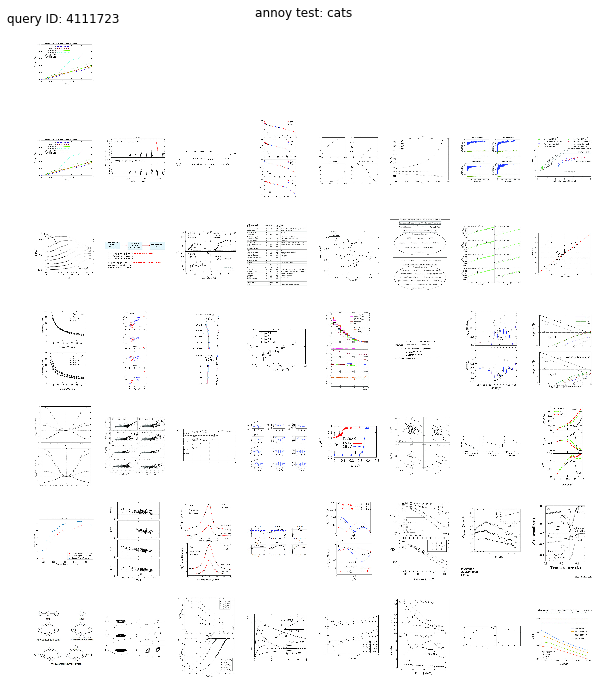

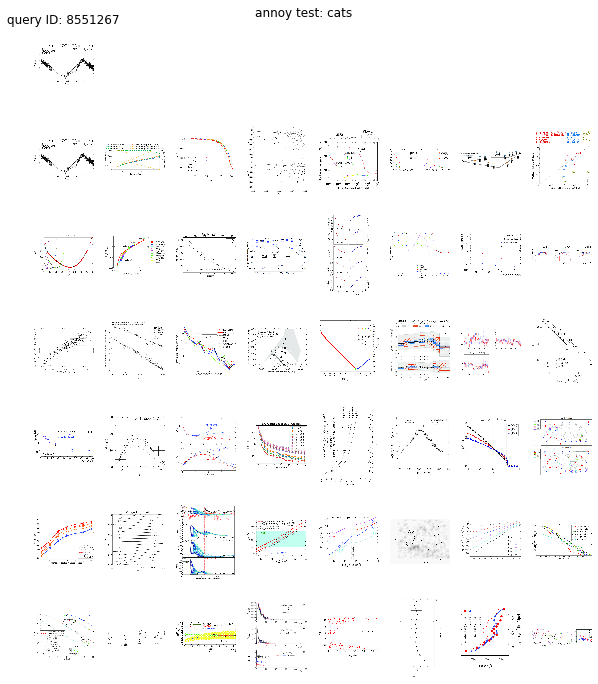

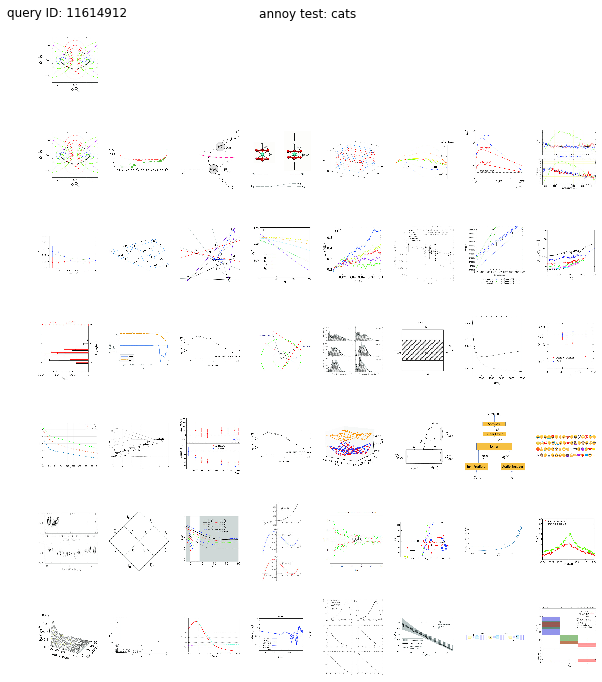

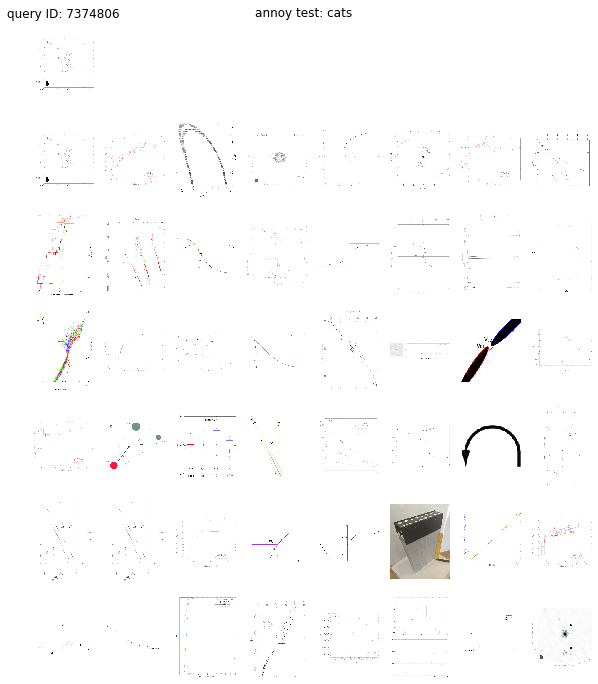

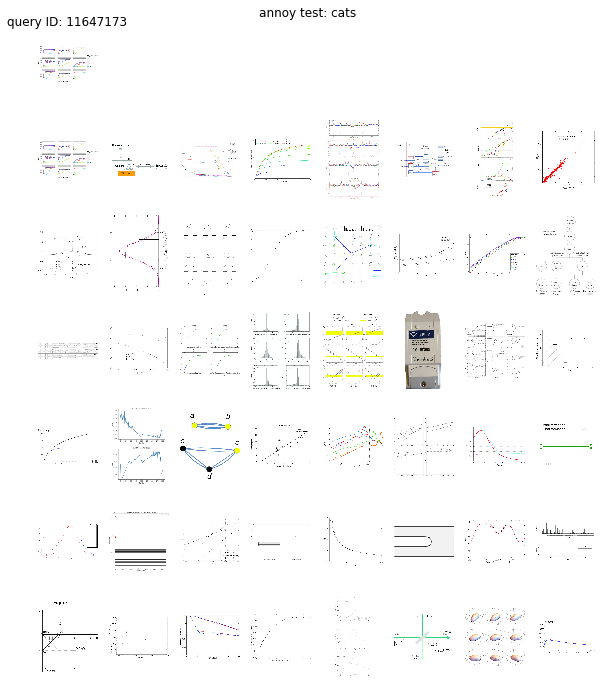

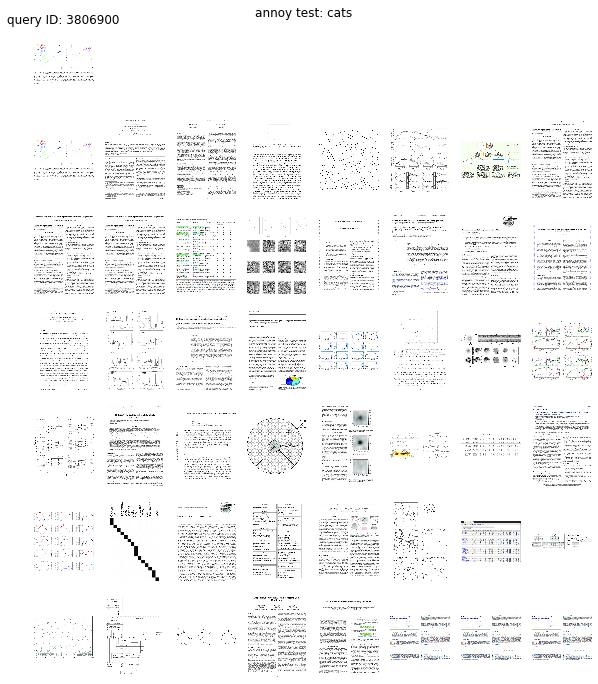

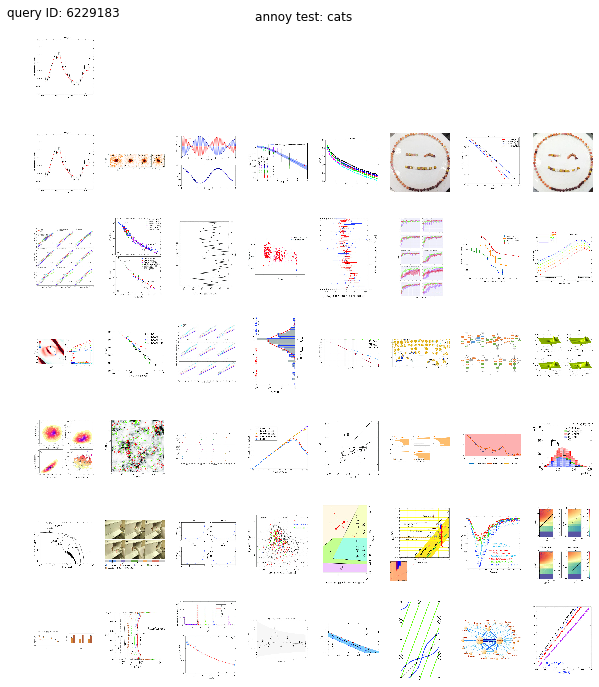

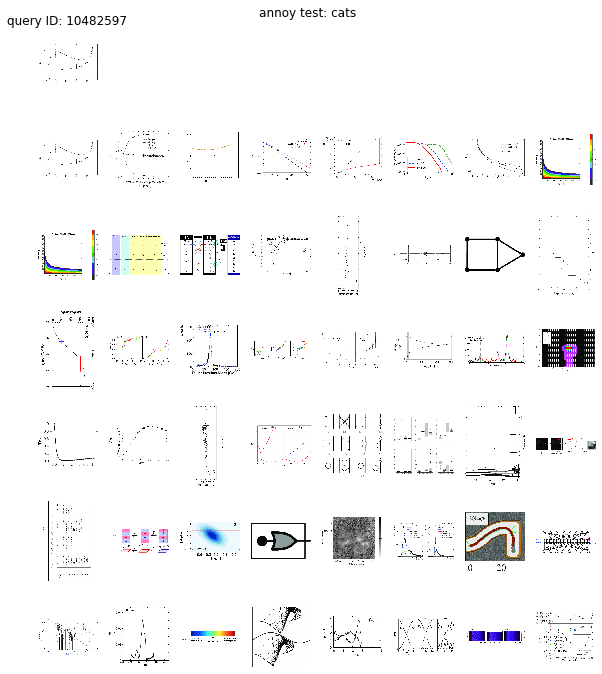

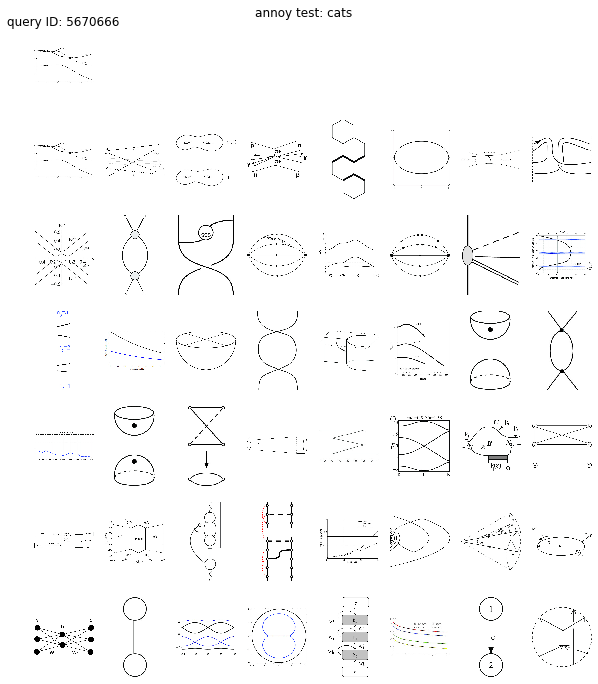

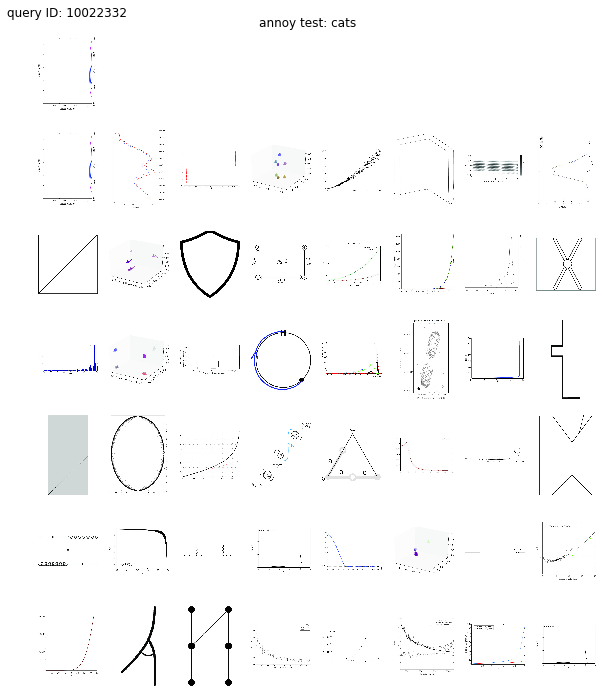

In [146]:
num_n = 50

for i in range(10):
    target_index = i
    print("index", target_index)
    indexes = t.get_nns_by_item(target_index, num_n)
    print(indexes)
    target_images = np.array(images)[np.array(indexes)]
    
    xdim = 8
    ydim = 7

    fig, ax = plt.subplots(ydim, xdim)
    fig.set_size_inches(10, 12)
#     fig.patch.set_facecolor('0.98')
    #     print(filepaths[index].split(".")[0])
    title_string = f'annoy test: {mode}'
#     print(title_string)
    fig.suptitle(title_string, y=0.9)

    # display the query image
    query_image = mpimg.imread(images[target_index])
    ax[0, 0].imshow(query_image, cmap='Greys_r')
    ax[0, 0].set_title("query ID: " + filepaths[target_index].split(".")[0], pad=20)

    for i in range(xdim):
        ax[0, i]. axis('off')

    for y in range(1, ydim):
        for x in range(xdim):
#             print(f"x: {x}, y: {y}")
            grid_index = (y * xdim) + x - xdim
#             print(f"grid_index: {grid_index}")
            current_image = mpimg.imread(target_images[grid_index])
            ax[y, x].imshow(current_image, cmap='Greys_r')
            ax[y, x].axis('off')

#     plt.tight_layout(pad=0.5)
    savename = f"{ann_filename.split('.')[0]}_{target_index}.jpg"
    # savename = f'{query_image_idx:04}' + "_" + filepaths[index].split(".")[0] + "_strip_1m.jpg"
    plt.savefig(savename, dpi=300, bbox_inches='tight')
    # print("completed", index)
    # print("time taken", "{:.4f}".format(time.time() - start))